**D3APL: Aplicações em Ciência de Dados** <br/>
IFSP Campinas

Prof. Dr. Samuel Martins (Samuka) <br/><br/>

<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.

# Animal Dataset - v5
We will evaluate some **multiclass classification** CNNs to predict the classes of the **Animal Dataset**: https://www.kaggle.com/datasets/alessiocorrado99/animals10


Target goals:
- Allocating GPU memory on demand
- Evaluate VGG16 by transfer learning with the original input: 224x224x3
- Training on Large Datasets That Don’t Fit In Memory in Keras

## 1. Set up

#### 1.1 TensorFlow

In [1]:
import tensorflow as tf

In [2]:
tf.__version__

'2.8.0'

**GPU available?**

In [3]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


### 1.2 Allocating memory on demand
By default `TensorFlow` allocates _GPU memory_ for the **lifetime of a process**, not the lifetime of the **session object** (so memory can linger much longer than the object). That is why memory is lingering after you stop the program. <br/>
Instead, we can indicate to `TensorFlow` allocates **memory on demand**.

Sources: <br/>
https://www.tensorflow.org/guide/gpu#limiting_gpu_memory_growth

https://python.tutorialink.com/cuda-error-out-of-memory-python-process-utilizes-all-gpu-memory/ <br/>
https://blog.fearcat.in/a?ID=00950-b4887eea-22e7-4853-b4de-fe746a9e56e6 <br/>
https://stackoverflow.com/a/45553529

In [4]:
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


### 1.2 Fixing the seed for reproducibility (optional)
That's a try for reprodubility in Keras. See more on:
- https://stackoverflow.com/a/59076062
- https://machinelearningmastery.com/reproducible-results-neural-networks-keras/

In [5]:
import os
import tensorflow as tf
import numpy as np
import random

def reset_random_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    
# make some random data
reset_random_seeds()

### 1.3. Dataset
**Animal Dataset**: https://www.kaggle.com/datasets/alessiocorrado99/animals10

In [6]:
import pandas as pd
import numpy as np
import os

In [7]:
# train
dataset_df_train = pd.read_csv('../datasets/animals-dataset/preprocessed/train.csv')

# validation
dataset_df_validation = pd.read_csv('../datasets/animals-dataset/preprocessed/validation.csv')

# test
dataset_df_test = pd.read_csv('../datasets/animals-dataset/preprocessed/test.csv')

## 2. Building and Training a CNN via Keras

### 2.1 Defining the Network Architecture - VGG16
Original paper: https://arxiv.org/pdf/1409.1556.pdf <br/>
Tutorial: https://medium.com/@mygreatlearning/everything-you-need-to-know-about-vgg16-7315defb5918 <br/>
Tutorial: https://towardsdatascience.com/step-by-step-vgg16-implementation-in-keras-for-beginners-a833c686ae6c


<img src='figs/vgg16.png' />

<img src='figs/vgg16_architecture.jpeg' />


<br/>

**Getting the VGG16 with trained weights as our base model**

In [ ]:
# https://keras.io/api/applications/vgg/
# https://towardsdatascience.com/transfer-learning-with-vgg16-and-keras-50ea161580b4

from tensorflow.keras.applications import VGG16

# consider the original input shape: 224x224x4
base_model = VGG16(include_top=None, weights="imagenet", input_shape=(224, 224, 3))
base_model.trainable = False

In [9]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Note that **there are no Trainable parameters**.

<br/>

**Plugging a Fully-connected network classifier into the base model**

In [10]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense


model = Sequential([
    # our base model
    base_model,
    
    Flatten(),
    
    # FC classifier
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    
    Dense(10, activation='softmax')
])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 128)               3211392   
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 10)                650       
                                                                 
Total params: 17,934,986
Trainable params: 3,220,298
Non-trainable params: 14,714,688
_________________________________________________________________


Although our **model** has _a lot of parameters_, there is a **smaller** number of **trained parameters**.

In [12]:
from tensorflow.keras.optimizers import Adam
opt = Adam(learning_rate=0.001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

### 2.2 Preprocessing

- **Image Resizing**
    + Since the **input layer's shape** and the **images' shape** ***are different***, we need to **resize** the images to the **input layer's shape**.
    + Let's use the function `c2.resize()` for that: https://learnopencv.com/image-resizing-with-opencv/#resize-by-wdith-height
- **Intensity (feature) Scaling**
    + Animals dataset contain 24-bit color images, i.e., it is a color image where each channel is a 8-bit grayscale image (values from 0 to 255)
    + We will simply rescale the values to [0, 1] by dividing them by 255.
- **Label Encoder**
    + Encode the string classes into class integers from 0 to n_classes-1
    + https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html

However, the _preprocessing data_ **may not fit into our memory**!!! <br/>
So, we need to deal with that first!

### 2.3 Training on Large Datasets That Don’t Fit In Memory in Keras

As our dataset is **too large to fit in memory**, we have to load the dataset from the _hard disk_ in _batches_ to our memory. <br/>
We can do that by creating a **Keras Creation of Custom Generator**.

https://medium.com/@mrgarg.rajat/training-on-large-datasets-that-dont-fit-in-memory-in-keras-60a974785d71 <br/>
https://medium.datadriveninvestor.com/keras-training-on-large-datasets-3e9d9dbc09d4 <br/>

https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence

In [13]:
from tensorflow.keras.utils import Sequence
import numpy as np
import math
import cv2

from animals_utils import preprocess_animals_dataset


class MyGenerator(Sequence):
    def __init__(self, dataset_df, label_encoder, batch_size, new_dims=(224, 224)):
        self.dataset_df = dataset_df
        self.label_encoder = label_encoder
        self.batch_size = batch_size
        self.new_dims = new_dims
    
    
    def __len__(self):
        n_samples = self.dataset_df.shape[0]
        
        return math.ceil(n_samples / float(self.batch_size))
    
    
    def __getitem__(self, idx):
        batch_begin = idx * self.batch_size
        batch_end = (idx + 1) * self.batch_size
        
        batch_df = self.dataset_df[batch_begin:batch_end]
        
        X_batch, y_batch = preprocess_animals_dataset(batch_df, self.label_encoder, self.new_dims, verbose=0)
                
        return X_batch, y_batch
    

In [14]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(dataset_df_train['class'])

LabelEncoder()

In [15]:
batch_size = 32

training_batch_generator = MyGenerator(dataset_df_train, label_encoder, batch_size, new_dims=(224, 224))
validation_batch_generator = MyGenerator(dataset_df_validation, label_encoder, batch_size, new_dims=(224, 224))
test_batch_generator = MyGenerator(dataset_df_test, label_encoder, batch_size, new_dims=(224, 224))

In [16]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [17]:
# https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit
history = model.fit(training_batch_generator, epochs=100, validation_data=validation_batch_generator, callbacks=[early_stopping_cb],
                    # Used for generator or keras.utils.Sequence input only
                    use_multiprocessing=True, workers=16, max_queue_size=32)

Epoch 1/100
200/200 [==============================] - 26s 122ms/step - loss: 1.0810 - accuracy: 0.6398 - val_loss: 0.7191 - val_accuracy: 0.7431
Epoch 2/100
200/200 [==============================] - 26s 126ms/step - loss: 0.4271 - accuracy: 0.8612 - val_loss: 0.6528 - val_accuracy: 0.7794
Epoch 3/100
200/200 [==============================] - 26s 127ms/step - loss: 0.2133 - accuracy: 0.9373 - val_loss: 0.7022 - val_accuracy: 0.7750
Epoch 4/100
200/200 [==============================] - 26s 126ms/step - loss: 0.1105 - accuracy: 0.9695 - val_loss: 0.6725 - val_accuracy: 0.7956
Epoch 5/100
200/200 [==============================] - 27s 126ms/step - loss: 0.0583 - accuracy: 0.9855 - val_loss: 0.6814 - val_accuracy: 0.8025
Epoch 6/100
200/200 [==============================] - 27s 128ms/step - loss: 0.0241 - accuracy: 0.9966 - val_loss: 0.6498 - val_accuracy: 0.8238
Epoch 7/100
200/200 [==============================] - 27s 134ms/step - loss: 0.0125 - accuracy: 0.9984 - val_loss: 0.6876 -

#### **Visualizing the training history**

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

history_df = pd.DataFrame(history.history)

Text(0, 0.5, 'Score')

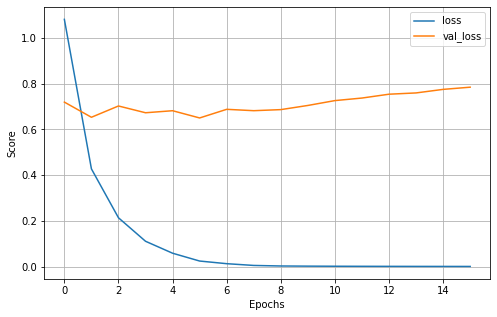

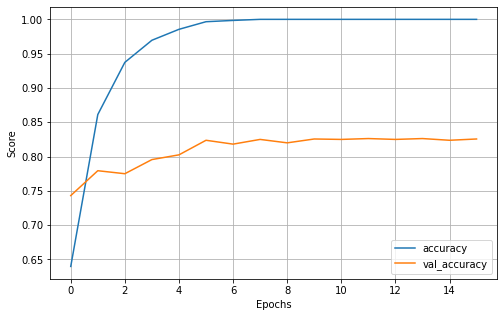

In [19]:
history_df[['loss', 'val_loss']].plot(figsize=(8, 5))
plt.grid(True)
# plt.xticks(range(100))
plt.xlabel('Epochs')
plt.ylabel('Score')

history_df[['accuracy', 'val_accuracy']].plot(figsize=(8, 5))
plt.grid(True)
# plt.xticks(range(100))
plt.xlabel('Epochs')
plt.ylabel('Score')

## 3. Evaluating and Predicting New Samples by using our Overfitted Model

#### **Evaluation**
https://www.tensorflow.org/api_docs/python/tf/keras/Sequential#evaluate

In [20]:
model.evaluate(test_batch_generator)

63/63 [==============================] - 5s 86ms/step - loss: 0.6943 - accuracy: 0.8150


[0.6943294405937195, 0.8149999976158142]

#### **Prediction**
https://www.tensorflow.org/api_docs/python/tf/keras/Sequential#predict

In [21]:
y_test_proba = model.predict(test_batch_generator)
y_test_proba

array([[9.04837871e-10, 6.34995831e-06, 1.19230970e-06, ...,
        1.37827708e-03, 3.56258772e-10, 2.26589347e-09],
       [4.97801904e-11, 6.62256545e-13, 1.44866798e-13, ...,
        4.28230237e-07, 6.64773412e-14, 1.52565718e-13],
       [3.07175273e-04, 1.60718657e-04, 1.09429576e-03, ...,
        5.74150860e-01, 5.82435634e-04, 1.32841030e-02],
       ...,
       [2.67725009e-11, 1.18540255e-09, 9.99999285e-01, ...,
        7.67838117e-07, 7.63510416e-14, 4.36011255e-10],
       [9.99998927e-01, 1.82912810e-10, 2.17701170e-11, ...,
        3.45969815e-11, 1.11398015e-06, 1.29140620e-09],
       [4.30094104e-07, 3.37807316e-04, 5.80905102e-08, ...,
        5.42806902e-06, 1.14673554e-07, 9.99642372e-01]], dtype=float32)

#### **Class Prediction**
https://stackoverflow.com/a/69503180/7069696

In [22]:
y_test_pred = np.argmax(y_test_proba, axis=1)
y_test_pred

array([4, 5, 7, ..., 2, 0, 9])

In [23]:
label_encoder.classes_

array(['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse',
       'sheep', 'spider', 'squirrel'], dtype=object)

In [24]:
from sklearn.metrics import classification_report

y_test = label_encoder.transform(dataset_df_test['class'])
class_names = label_encoder.classes_

print(classification_report(y_test, y_test_pred, target_names=[name for name in class_names]))

              precision    recall  f1-score   support

   butterfly       0.94      0.94      0.94       200
         cat       0.82      0.81      0.81       200
     chicken       0.87      0.81      0.84       200
         cow       0.74      0.79      0.76       200
         dog       0.77      0.74      0.76       200
    elephant       0.73      0.93      0.82       200
       horse       0.86      0.75      0.80       200
       sheep       0.76      0.70      0.73       200
      spider       0.85      0.94      0.89       200
    squirrel       0.84      0.74      0.79       200

    accuracy                           0.81      2000
   macro avg       0.82      0.82      0.81      2000
weighted avg       0.82      0.81      0.81      2000



We got the **best accuracy** so far.